# Parlamentarni izbori 2016, or:

## How I Learned to Stop Worrying and Love D'Hondt

&nbsp;

**Autor**: Miran T.

&nbsp;

> Republika Hrvatske podijeljena je u 10 izbornih jedinica. U svakoj izbornoj jedinici se bira po 14 zastupnika.  
Birači koji nemaju prebivalište u Republici Hrvatskoj, glasuju u 11. izbornoj jedinici za dijasporu, i biraju 3 zastupnika.  
Pripadnici nacionalnih manjina odlučuju hoće li glasati u jednoj od deset izbornih jedinica, ili u 12. izbornoj jedinici za dijasporu, u kojoj se bira 8 zastupnika.  
Broj zastupnika koji će biti izabrani u pojedinoj izbornoj jedinici određuje se po [D'Hondtovoj metodi](https://en.wikipedia.org/wiki/D%27Hondt_method), a u raspodijeli zastupničkih mjesta sudjeluju sve izborne liste koje osvoje barem 5% važećih glasova.

Izbori za zastupnike u Hrvatski sabor 2016. održani su 11. rujna 2016. godine. 

U ovom radu prikazat će se rezultati navedenih izbora (za prvih 10 izbornih jedinica - bez manjina i dijaspore) u raznim imaginarnim scenarijima:

- [cijela RH je jedna izborna jedinica](#Cijela-Hrvatska-je-jedna-izborna-jedinica)
- [izborni prag je 3%](#Izborni-prag-je-3%)
- [cijela RH je jedna izborna jedinica i izborni prag je 3%](#Cijela-Hrvatska-je-jedna-izborna-jedinica-i-izborni-prag-je-3%)
- [u svakoj izbornoj jedinici bira se 12 zastupnika](#U-svakoj-izbornoj-jedinici-bira-se-12-zastupnika)
- [korištenje Websterove metode](#Kori%C5%A1tenje-Websterove-metode)
- [Websterova metoda i izborni prag od 3%](#Websterova-metoda-i-izborni-prag-od-3%)

&nbsp; 

*Napomena: naslov je referenca na film "Dr. Strangelove" i njime se ne izražava autorova ljubav prema nijednom izbornom sustavu ili metodi.*

&nbsp;

&nbsp;


## Python kod

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
plt.style.use('ggplot')
solarized = ["#268bd2", "#cb4b16"]
sns.set_palette(solarized)
plt.rcParams['savefig.facecolor'] = (0, 0, 0, 0)
plt.rcParams['axes.facecolor'] = '#eee8d5'

In [2]:
df = pd.read_csv('./datasets/hr_izbori.csv', index_col='Izborna jedinica')
df

,HDZ,SDP,MOST,Živi zid,Bandić,Pametno,HDSSB,IDS,Ukupno
Izborna jedinica,,,,,,,,,
1,62310,77541,20520,11603,8488,9526,NaN,NaN,196963
2,69224,68603,16776,13590,18011,2592,NaN,NaN,194774
3,43786,93164,10507,11767,8349,1838,NaN,NaN,177245
4,60380,46694,13346,11311,2519,1684,15540.0,NaN,157797
5,77278,41382,15591,8962,5141,1090,8033.0,NaN,164029
6,59653,58746,15763,11200,12899,3361,NaN,NaN,170017
7,76049,76786,19723,18418,10413,5238,NaN,2455.0,216392
8,35753,63890,11588,13669,2261,2891,NaN,40725.0,178659
9,102768,49843,26358,8620,4781,2529,NaN,NaN,207117


In [3]:
def izracunaj_zastupnike(data=df, izborni_prag=0.05, coeff=1,
                         zastupnika_po_jedinici=14):
    
    def zastupnici_po_jedinici(glasovi):
        presli_prag = glasovi[glasovi > izborni_prag*glasovi.Ukupno].drop('Ukupno')
        quotient = [presli_prag//(coeff*i+1) for i in range(zastupnika_po_jedinici)]
        min_glasova = sorted(np.array(quotient).ravel())[-zastupnika_po_jedinici]
        zastupnici = pd.DataFrame(quotient)
        return zastupnici[zastupnici >= min_glasova].count()
    
    zastupnici_po_jedinicama = []
    if isinstance(data, pd.DataFrame):
        
        for jedinica in data.index.values:
            glasovi = data.loc[jedinica]
            zastupnici = zastupnici_po_jedinici(glasovi)
            zastupnici_po_jedinicama.append(zastupnici)
    else:
        zastupnici_po_jedinicama.append(zastupnici_po_jedinici(data))

    return (pd.DataFrame(zastupnici_po_jedinicama, index=df.index)
            .reindex(columns=df.columns)
            .drop('Ukupno', axis=1)
           )

In [4]:
def plot_zastupnika(rezultati, usporedi_s=None, tekst='', filename=None):
    cols = 2 if usporedi_s is not None else 1
    if cols == 1:
        fig, axes = plt.subplots(rezultati.shape[0], cols, 
                                 figsize=(8, 12), sharex='col')
    else:
        fig, axes = plt.subplots(rezultati.shape[0], cols, 
                                 figsize=(10, 12), sharex='col')
    axes = axes.ravel()
    
    def plotaj_jedinicu(jedinica, desni_graf=False):
        jedinica.plot(kind='barh', width=0.8, ax=ax, colormap='tab20c')
        ax.tick_params(axis='both', length=0, which='both')
        
        if not desni_graf:
            ax.set_ylabel('{}. IJ'.format(i))
            ax.set_xlim(0, 8)
            ax.set_xlabel('Broj zastupnika')
        else:
            ax.axvline(x=0, color='k')
            ax.set_yticklabels([])
            ax.set_xlim(-4, 4)
            ax.set_xlabel('Razlika u broju zastupnika')
            
    
    for i, ax in enumerate(axes[::cols], 1):
        izb_jed = rezultati.loc[i].dropna().sort_index(ascending=False)
        plotaj_jedinicu(izb_jed)
    axes[0].set_title('Broj zastupnika po izbornim jedinicama')
        
    if usporedi_s is not None:
        razlike = rezultati.sub(usporedi_s, fill_value=0)
        
        for i, ax in enumerate(axes[1::cols], 1):
            izb_jed = razlike.loc[i].dropna().sort_index(ascending=False)
            plotaj_jedinicu(izb_jed, desni_graf=True)
        
        axes[0].set_title('Broj zastupnika po izbornim jedinicama\n'
                          '({})'.format(tekst))
        axes[1].set_title('Razlika u odnosu na sadašnji sustav')
        fig.subplots_adjust(wspace=0.1)
        
    if filename:
        plt.tight_layout()
        plt.savefig('./figures/hr-izbori/{}_01.png'.format(filename), dpi=70)

In [5]:
zbroji_zastupnike = lambda x: x.sum().sort_values(na_position='first')


def plot_ukupno_zastupnika(rezultati, usporedi_s=None, tekst='', 
                           xlim=(-4, 4), filename=None):
    def plotaj(graf, ax):
        graf.plot(kind='barh', width=0.5, ax=ax, colormap='tab20c')
        ax.tick_params(axis='both', length=0, which='both')
    
    cols = 2 if usporedi_s is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(5*cols, 5))

    if cols == 1:
        ax1 = axes
        plotaj(rezultati, ax1)
    else:
        ax1, ax2 = axes
        plotaj(rezultati, ax1)
        razlike = rezultati.sub(usporedi_s.reindex_like(rezultati), fill_value=0)
        plotaj(razlike, ax2)

    for bar, value in zip(ax1.patches, rezultati.values):
        if value > 1:
            x = bar.get_width()
            y = bar.get_y()
            dx = ax1.get_xbound()[1] / 100
            dy = bar.get_height() / 2
            ax1.text(x-dx, y+dy, int(value), va='center', ha='right', color='white')
            
            
    _ = (ax1.set_title('Ukupni broj zastupnika'),
         ax1.set_xlim(0, 60),
         ax1.set_xlabel('Broj zastupnika'),
         ax1.set_ylabel('Stranka')
        )
    
    if cols == 2:
         _ = (ax1.set_title('Ukupni broj zastupnika\n'
                            '({})'.format(tekst)),
              ax2.set_title('Razlika u odnosu na sadašnji sustav'),
              ax2.axvline(x=0, color='k'),
              ax2.set_yticklabels([]),
              ax2.set_xlim(xlim),
              ax2.set_xlabel('Razlika u broju zastupnika'),
              fig.subplots_adjust(wspace=0.1),
             )
    if filename:
        plt.tight_layout()
        plt.savefig('./figures/hr-izbori/{}_02.png'.format(filename), dpi=70)

## Trenutni izborni sustav

Rezultati po izbornim jedinicama i ukupni rezultati dobiveni po trenutno važećim pravilima (D'Hondtova metoda, 5% izborni prag).

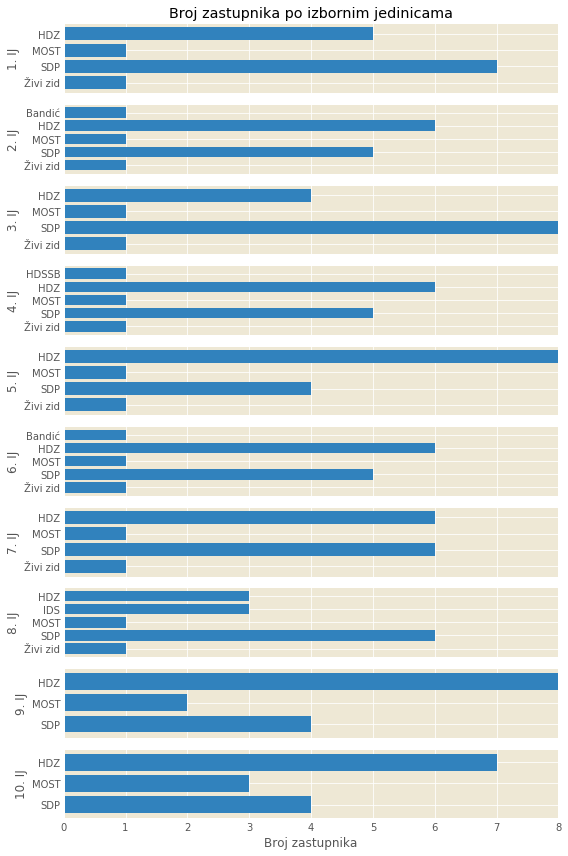

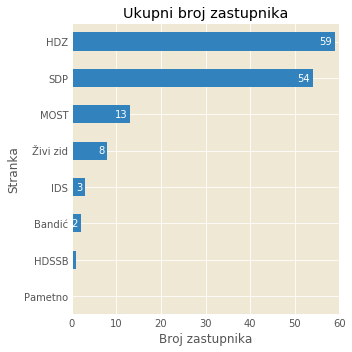

In [6]:
zastupnici = izracunaj_zastupnike()
zastupnici_ukupno = zbroji_zastupnike(zastupnici)
filename = '01_trenutno'

plot_zastupnika(zastupnici, filename=filename)
plot_ukupno_zastupnika(zastupnici_ukupno, filename=filename)

## Cijela Hrvatska je jedna izborna jedinica

U ovom scenariju promatramo kako bi izgledala raspodjela mandata u Saboru kada bi cijela Hrvatska bila jedna izborna jedinica u kojoj se bira 140 zastupnika.

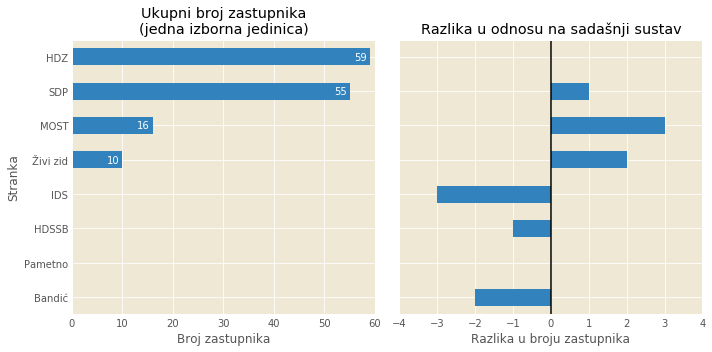

In [7]:
jedna_izborna = df.sum()
jedna_zastupnici = (izracunaj_zastupnike(jedna_izborna, zastupnika_po_jedinici=140)
                    .iloc[1]
                    .fillna(0)
                    .sort_values()
                   )
tekst = 'jedna izborna jedinica'
filename = '02_jedna'

plot_ukupno_zastupnika(jedna_zastupnici, zastupnici_ukupno, 
                       tekst=tekst, filename=filename)

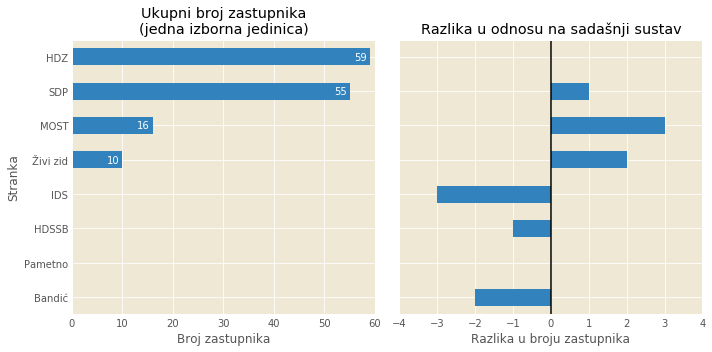

In [8]:
jedna_izborna = df.sum()
jedna_zastupnici = (izracunaj_zastupnike(jedna_izborna, zastupnika_po_jedinici=140)
                    .iloc[1]
                    .fillna(0)
                    .sort_values()
                   )
tekst = 'jedna izborna jedinica'
filename = '02_jedna'

plot_ukupno_zastupnika(jedna_zastupnici, zastupnici_ukupno, 
                       tekst=tekst, filename=filename)

Pobjednici ovakvih izbora (u odnosu na trenutne izbore) su MOST i Živi zid, koji osvajaju 25% više zastupničkih mjesta. 
Gubitnici su, logično, stranke koje su uspjele osvojiti mandate samo u pojedinim izbornim jedinicama: IDS, HDDSB i Bandić.

## Izborni prag je 3%

Često se može čuti kako je hrvatski izborni prag od 5% previsok i da bi ga trebalo sniziti kako bi se dala šansa manjim strankama.  
Koliko bi se promijenila slika u Saboru da je izborni prag 3% umjesto dosadašnjih 5%?

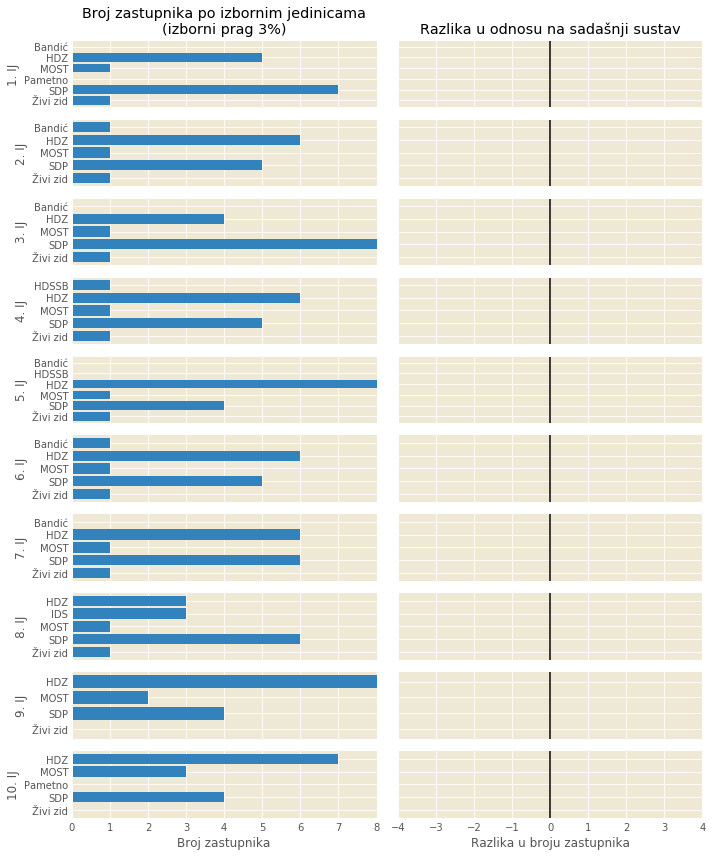

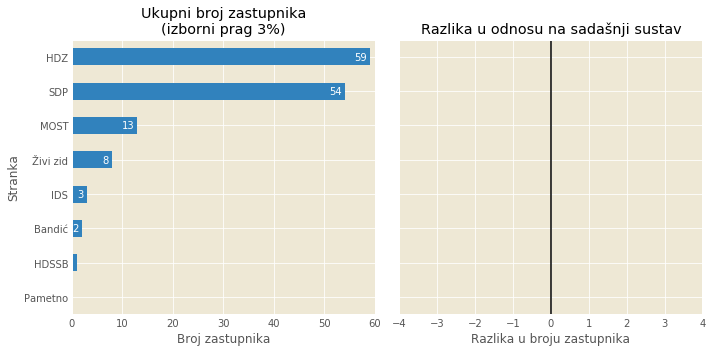

In [9]:
zastupnici_3posto = izracunaj_zastupnike(izborni_prag=0.03)
zastupnici_3posto_ukupno = zbroji_zastupnike(zastupnici_3posto)
tekst = 'izborni prag 3%'
filename = '03_prag3posto'

plot_zastupnika(zastupnici_3posto, zastupnici, tekst=tekst, filename=filename)
plot_ukupno_zastupnika(zastupnici_3posto_ukupno, zastupnici_ukupno, tekst=tekst, filename=filename)

Suprotno nagađanjima, vidimo da smanjenjem izbornog praga na 3% ne bi došlo do nikakvih promjena u Saboru: osvojeni mandati u svim izbornim jedinicama ostaju jednaki kao i kod trenutnog sustava.  
Ono što se može primijetiti (na gornjem grafu) je veliki broj slučajeva gdje stranke prelaze izborni prag, ali nemaju dovoljan broj glasova za osvajanje mandata: Bandić u čak četiri izborne jedinice, Pametno i Živi zid u dvije izborne jedinice, a HDSSB u jednoj.

## Cijela Hrvatska je jedna izborna jedinica i izborni prag je 3%

Kombinacijom prethodna dva scenarija, dobivamo podjelu zastupničkih mjesta kada bi cijela Hrvatska bila jedna izborna jedinica uz izborni prag od 3%, kako bi se povećala šansa strankama koje su nepopularne u nekim izbornim jedinicama.

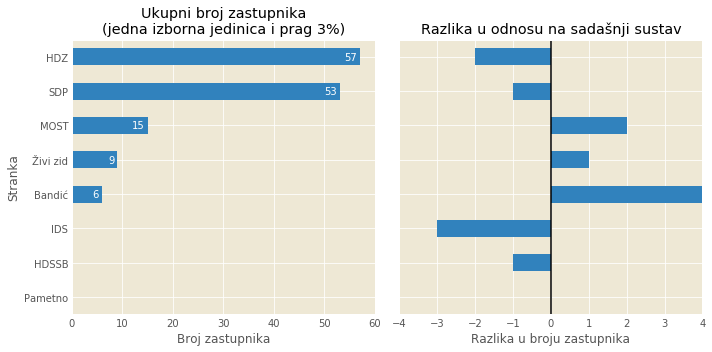

In [10]:
jedna_izborna = df.sum()
jedna_zastupnici = (izracunaj_zastupnike(jedna_izborna, 
                                         zastupnika_po_jedinici=140, 
                                         izborni_prag=0.03)
                    .iloc[1]
                    .fillna(0)
                    .sort_values()
                   )
tekst = 'jedna izborna jedinica i prag 3%'
filename = '04_jedna3posto'

plot_ukupno_zastupnika(jedna_zastupnici, zastupnici_ukupno, 
                       tekst=tekst, filename=filename)

Za razliku od jedne izborne jedinice uz izborni prag od 5%, kada Bandić ostaje bez ijednog mandata, u ovakvom scenariju postaje relativni pobjednik koji je utrostručio broj zastupničkih mjesta.  
Lokalnim strankama (IDS, HDSSB), koje sudjeluju u samo dvije izborne jedinice, lokalna popularnost nije dovoljna za sudjelovanje u radu Sabora u ovakvom scenariju.

## U svakoj izbornoj jedinici bira se 12 zastupnika

U sklopu mjera štednje, u ovom scenariju se, umjesto dosadašnjih 14 zastupnika po izbornoj jedinici, bira samo 12 zastupnika u svakoj izbornoj jedinici.

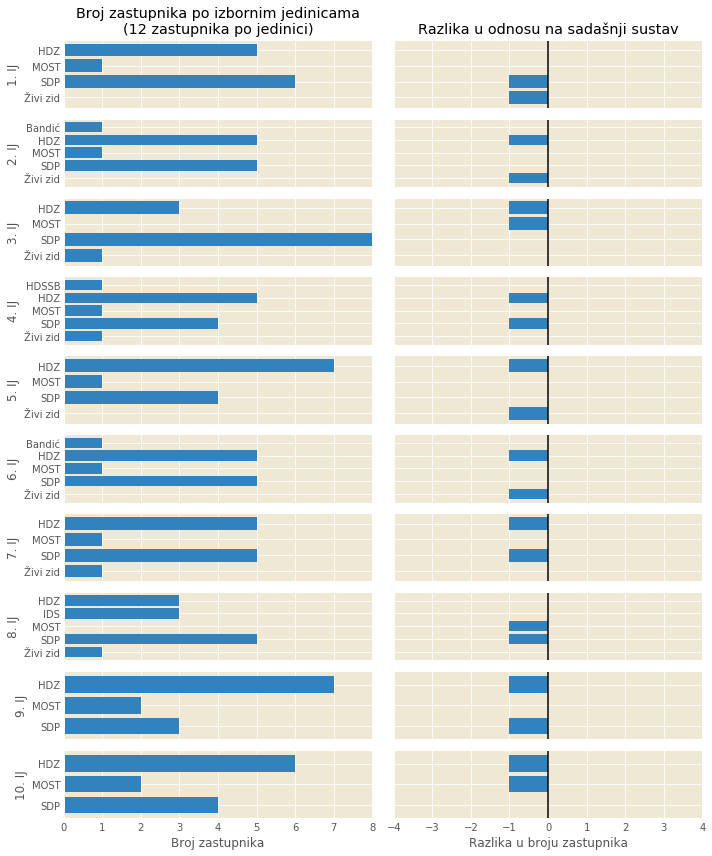

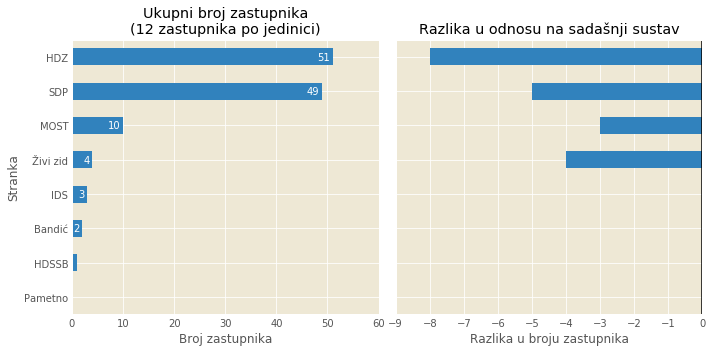

In [11]:
zastupnici_12 = izracunaj_zastupnike(zastupnika_po_jedinici=12)
zastupnici_12_ukupno = zbroji_zastupnike(zastupnici_12)

tekst = '12 zastupnika po jedinici'
filename = '05_12zastupnika'

plot_zastupnika(zastupnici_12, zastupnici, tekst=tekst, filename=filename)
plot_ukupno_zastupnika(zastupnici_12_ukupno, zastupnici_ukupno, 
                       tekst=tekst, xlim=(-9, 0), filename=filename)

Smanjenje broja zastupnika, čak i ako se radi o samo dva zastpunika manje po izbornoj jedinici, najgore pogađa stranke koje su osvojile najviše mandata.  
Tri stranke s najmanjim brojem mandata zadržale bi sve svoje mandate i tako, relativno gledajući, ojačale svoju poziciju u Saboru.

## Korištenje Websterove metode

Više o metodi [ovdje](https://en.wikipedia.org/wiki/Webster/Sainte-Lagu%C3%AB_method).

Ukratko:  
Kod D'Hondt metode kvocijenti kojima se dijele glasovi iznose 1, 2, 3, 4, 5, itd.  
Kod Webster metode kvocijenti kojima se dijele glasovi iznose 1, 3, 5, 7, 9, itd. 

Neke od zemalja u kojima se koristi Websterova metoda: Norveška, Švedska, Njemačka (za izbor u Bundestag), te susjedna Bosna i Hercegovina.  
U teoriji, zbog većih kvocijenata, ova bi metoda trebala više pogodovati strankama koje su osvojile manji broj glasova.

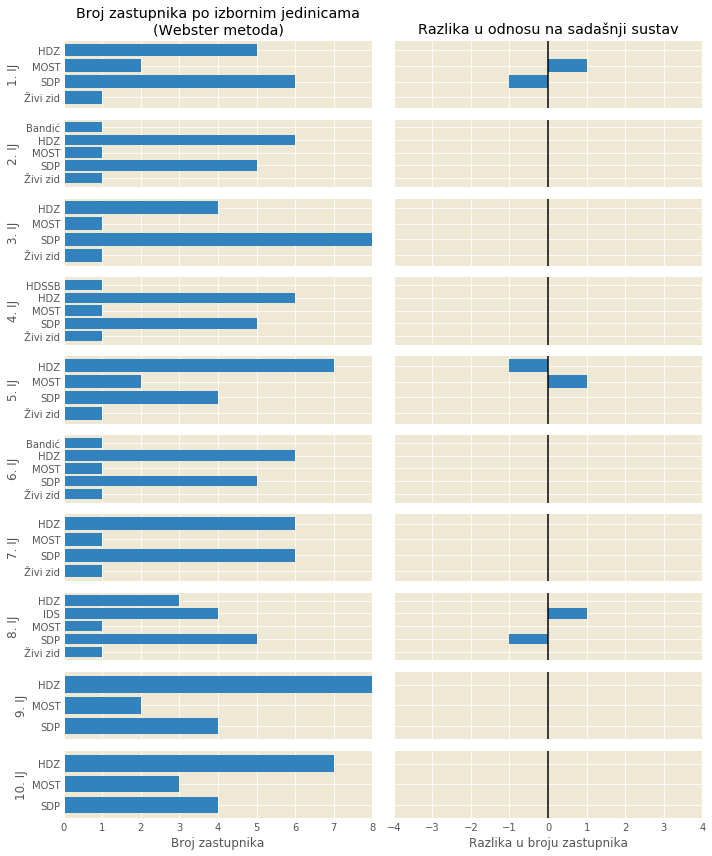

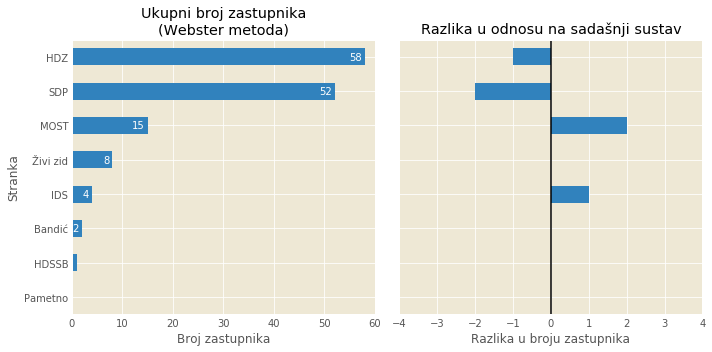

In [12]:
zastupnici_webster = izracunaj_zastupnike(coeff=2)
zastupnici_webster_ukupno = zbroji_zastupnike(zastupnici_webster)
tekst = 'Webster metoda'
filename = '06_webster'

plot_zastupnika(zastupnici_webster, zastupnici, tekst=tekst, filename=filename)
plot_ukupno_zastupnika(zastupnici_webster_ukupno, zastupnici_ukupno, 
                       tekst=tekst, filename=filename)

Dvije najveće stranke osvajaju ukupno tri mandata manje, što i nije velika razlika u odnosu na sadašnji sustav.

## Websterova metoda i izborni prag od 3%

Iako bi Websterova metoda trebala pogodovati manjim strankama, izborni prag od 5% predstavlja previsoku barijeru za neke od njih.  
Ranije smo vidjeli da [smanjenje izbornog praga na 3% kod D'Hondtove metode](#Izborni-prag-je-3%) ne donosi nikakvu promjenu.  
Kakvi su rezultati snižavanja izbornog praga na 3% kod Websterove metode?

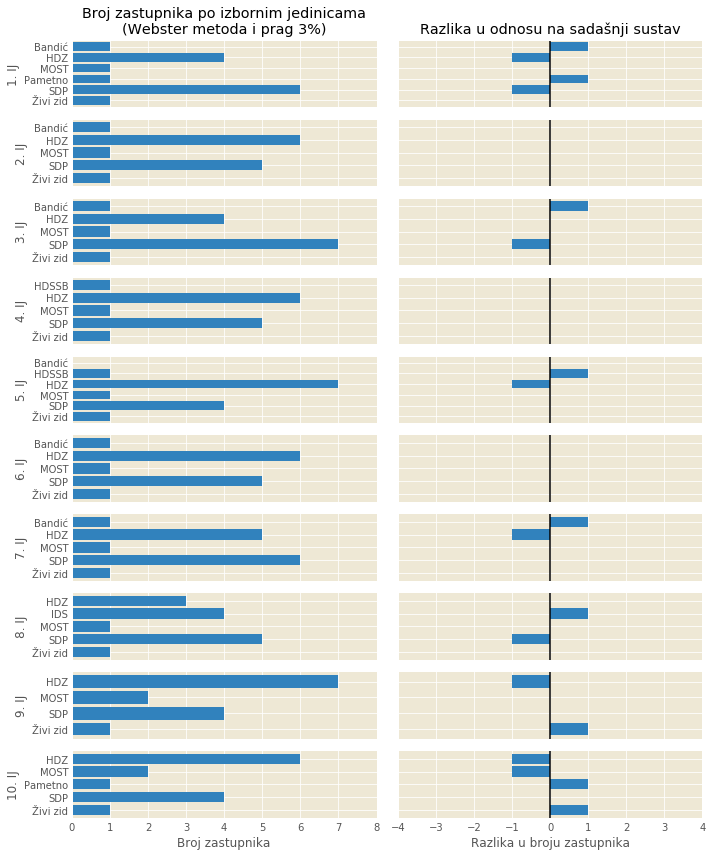

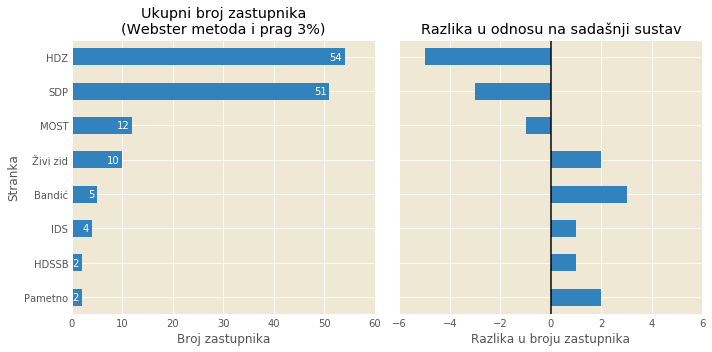

In [13]:
zastupnici_webster3 = izracunaj_zastupnike(coeff=2, izborni_prag=0.03)
zastupnici_webster3_ukupno = zbroji_zastupnike(zastupnici_webster3)
tekst = 'Webster metoda i prag 3%'
filename = '07_webster3posto'

plot_zastupnika(zastupnici_webster3, zastupnici, tekst=tekst, filename=filename)
plot_ukupno_zastupnika(zastupnici_webster3_ukupno, zastupnici_ukupno, 
                       filename=filename, tekst=tekst, xlim=(-6, 6))

Websterova metoda uz izborni prag od 3% ima Robin Hoodovska svojstva: smanjuje razlike u broju mandata između stranaka, pogodujući strankama s manje glasova, istovremeno uzimajući od stranaka s najviše mandata.  
Jedino u ovom scenariju stranka Pametno uspijeva postati parlamentarna stranka uz dva zastupnika iz 1. i 10. izborne jedinice.

# Zaključak

Koji izborni sustav je najbolji?  
Jedni će reći: ovisi koju stranku se pita, drugi će dodati: nijedan!

U ovom radu prikazano je nekoliko imaginarnih scenarija kako bi izgledao saziv Sabora kada bi birači glasovali isto kao 11. rujna, ali uz promijenjena izborna pravila:

- kada bi se ukinule izborne jedinice, to bi značilo kraj za lokalne stranke koje se inače pojavljuju samo u pojedinim izbornim jedinicama (IDS, HDSSB),
- smanjenje izbornog praga sa 5% na 3% samo po sebi ne bi donijelo nikakvu razliku kada su u pitanju mandati u Saboru,
- ali smanjenje izbornog praga na 3% uz primjenu Websterove metode izračuna mandata donosi dodatne zastupnike za stranke koje u sadašnjem sustavu imaju jednoznamenkasti broj mandata ili ne prelaze izborni prag,
- smanjenje broja saborskih zastupnika, ne mijenjajući ništa drugo, značilo bi značajno smanjenje broja mandata za najveće stranke, što bi dovelo do jačanja stranaka s malim brojem zastupnika.

&nbsp;

&nbsp;

&nbsp;


In [16]:
from IPython.core.display import HTML
def css_styling(): 
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()